In [1]:
%config Completer.use_jedi = False #for auto complete code

In [1]:
from scipy.interpolate import griddata
from osgeo import osr
from osgeo import gdal
from osgeo import gdal_array
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd

from shapely.geometry import mapping
from shapely.geometry import Polygon, Point, MultiLineString, MultiPoint
from collections import OrderedDict
import pandas as pd
import numpy as np

#plots
import matplotlib.pyplot as plt

#modflow
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf

import os, json

import mplleaflet

import sys
sys.path.insert(0, '../src')
from meshProperties import mesh_shape
from geoVoronoi import createVoronoi
#Create mesh object
vorMesh = createVoronoi()

#Define base refinement and refinement levels
vorMesh.defineParameters(maxRef = 80, minRef=20, stages=5)

ModuleNotFoundError: No module named 'scipy'

In [2]:
#Open limit layers and refinement definition layers
vorMesh.addLimit('basin','../examples/In/shp/Geospatial_model/ModelLimit1.shp')
vorMesh.addLayer('wells','../examples/In/shp/Geospatial_model/ModelWell2.shp')
vorMesh.addLayer('river','../examples/In/shp/Geospatial_model/ModelRiver2.shp')

In [3]:
#Generate point pair array
vorMesh.extractOrgVertices()

#Generate the point cloud and voronoi
vorMesh.createPointCloud()
vorMesh.generateVoronoi()

#check or create an output folder
outPath = '../examples/out/geospacial'
if os.path.isdir(outPath):
    print('The output folder %s exists'%outPath)
else:
    os.mkdir(outPath)
    print('The output folder %s has been generated.'%outPath)

#Export point data and voronoi polygons
#Points
vorMesh.getPointsAsShp('vertexOrg',outPath+'/vertexOrg.shp')
vorMesh.getPointsAsShp('vertexDist',outPath+'/vertexDist.shp')
vorMesh.getPointsAsShp('vertexBuffer',outPath+'/vertexBuffer.shp')
vorMesh.getPointsAsShp('vertexMaxRef',outPath+'/vertexMaxRef.shp')
vorMesh.getPointsAsShp('vertexMinRef',outPath+'/vertexMinRef.shp')
vorMesh.getPointsAsShp('vertexTotal',outPath+'/vertexTotal.shp')
#Polygons

vorMesh.getPolyAsShp('voronoiRegions',outPath+'/voronoiRegions.shp')


/----Sumary of points for voronoi meshing----/
Distributed points from layers: 139
Points from layer buffers: 1301
Points from max refinement areas: 20
Points from min refinement areas: 51
Total points inside the limit: 1362
/--------------------------------------------/

Time required for point generation: 1.14 seconds 

The output folder ../examples/out/geospacial exists


# DISV

In [4]:
mesh=mesh_shape('../examples/out/geospacial/voronoiRegions.shp')
gridprops=mesh.get_gridprops_disv()


Creating a unique list of vertices [[x1,y1],[x2,y2],...]


100%|███████████████████████████████████████████████████████████████████████████| 1362/1362 [00:00<00:00, 58749.67it/s]



Extracting cell2d data and grid index


100%|████████████████████████████████████████████████████████████████████████████| 1362/1362 [00:00<00:00, 2976.28it/s]


In [5]:
cell2d = gridprops['cell2d']
vertices = gridprops['vertices']
ncpl = gridprops['ncpl']
nvert = gridprops['nvert']
centroids=gridprops['centroids']

# Geometria del Acuifero

In [6]:
#Extact dem values for each centroid of the voronois
src = rasterio.open('../examples/in/rst/ModeloDem1.tif')
elevation=[x for x in src.sample(centroids)]

nlay = 3

mtop=np.array([elev[0] for i,elev in enumerate(elevation)])

zbot=np.zeros((nlay,ncpl))

AcuifInf_Bottom = -120

AcuifMed_Bottom = AcuifInf_Bottom + (0.5 * (mtop - AcuifInf_Bottom))

AcuifSup_Bottom = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom))


zbot[0,] = AcuifSup_Bottom 
zbot[1,] = AcuifMed_Bottom
zbot[2,] = AcuifInf_Bottom


# Creación del modelo Modflow 6

In [7]:
# create simulation
model_name = 'geo_model'
model_ws = '../examples/out/geospacial/model'
exe_name = '../exe/mf6.exe'

sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name,sim_ws=model_ws)

In [8]:
# create tdis package

nper = 11
tdis_rc = [(1.0,1,1.0)] + [(200 * 86400.0, 4, 1.0) for a in range(nper -1)]

tdis=flopy.mf6.ModflowTdis(sim, nper=nper, time_units='seconds',perioddata=tdis_rc)

In [9]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='BICGSTAB')

In [10]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True, newtonoptions=['under_relaxation'])

In [11]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,top=mtop, botm=zbot,nvert=nvert, vertices=vertices,cell2d=cell2d)

In [12]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)]))

In [13]:
Kx =[1E-5,5E-4,2E-4]
icelltype = [1,1,0]
npf = flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=icelltype,k=Kx)

In [14]:
sto=flopy.mf6.ModflowGwfsto(gwf,ss=1e-05, sy=0.15)

In [15]:
evtr = 1.2/365/86400
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0)

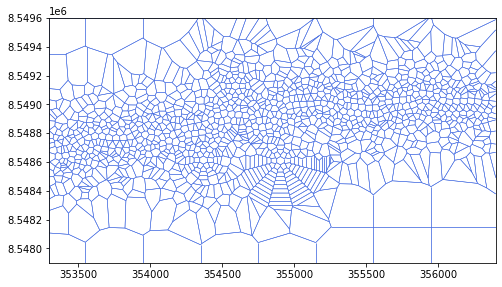

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='royalblue')

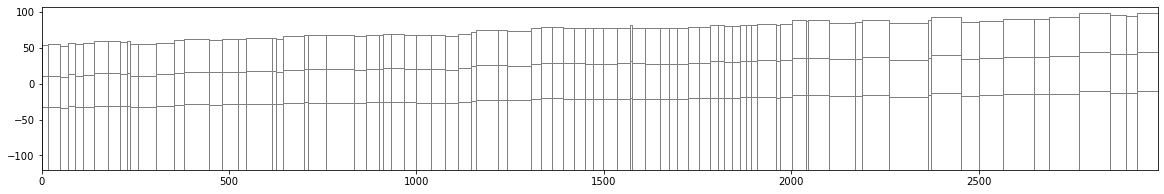

In [17]:
line = np.array([(353304.219,8548577.580), (356374.790,8548586.576)])

fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
linecollection = modelxsect.plot_grid()

## Para insertar las condiciones de recarga se realiza una interceptacion entre el shp de la zona de recarga y la grilla, de esta manera se optiene los indices de las celdas que conforman dicha zona

In [18]:
tgr = fgrid.VertexGrid(vertices, cell2d)
ix2 = GridIntersect(tgr)

C:\Users\saulm\anaconda3\envs\jose_env\lib\site-packages\flopy\utils\gridintersect.py:337: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


In [19]:
zone1=gpd.read_file('../examples/In/shp/Geospatial_model/ModelRechargeZone1.shp')
result=ix2.intersect(zone1['geometry'].loc[0])

C:\Users\saulm\anaconda3\envs\jose_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\saulm\anaconda3\envs\jose_env\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\saulm\anaconda3\envs\jose_env\lib\site-packages\descartes\patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


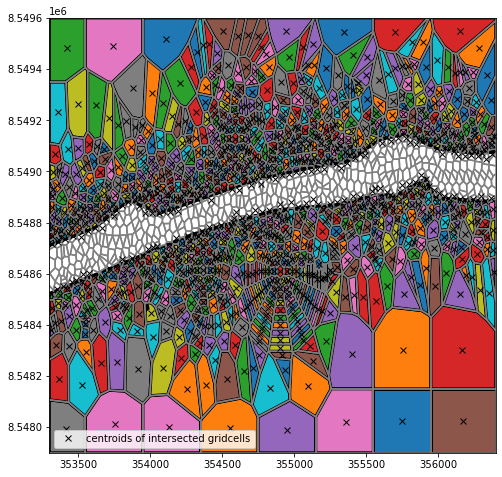

In [20]:
# install descartes 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_polygon(result, ax=ax, lw=3)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

In [21]:
#stress_period_data : [cellid, elev, cond, aux, boundname]
rchr = 0.2/365/86400
rchr_list = []
for i in result.cellids:
    rchr_list.append([0,i,rchr])
rchr_spd = {0:rchr_list}

In [22]:
rch = flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rchr_spd)

## Intersercción de pozos con la grilla

In [23]:
well_zone=gpd.read_file('../examples/In/shp/Geospatial_model/ModelWell2.shp')
list_wells=[]
for i in range(well_zone.shape[0]):
    
    list_wells.append(well_zone['geometry'].loc[i])
    
mp = MultiPoint(points=list_wells)

result=ix2.intersect(mp)

pump = -0.15
well_list = []
for i in result.cellids:
    well_list.append([1,i,pump])
well_spd = {1:well_list}

well=flopy.mf6.ModflowGwfwel(gwf,stress_period_data=well_spd)

## Intersección del rio con la grilla

In [24]:
river_zone=gpd.read_file('../examples/In/shp/Geospatial_model/ModelRiver2.shp')

In [25]:
result=ix2.intersect(river_zone['geometry'].loc[0])

In [26]:
river_list = []
for i in result.cellids:
    river_list.append([0,i,mtop[i],0.01,mtop[i]-1])
river_spd = {0:river_list}

In [27]:
river=flopy.mf6.ModflowGwfriv(gwf,stress_period_data=river_spd)

## Condición regional de gradiente hidráulico

In [28]:
boundaries_zone=gpd.read_file('../examples/In/shp/Geospatial_model/ModelGHB1.shp')

In [29]:
list_boundaries=[]
for i in range(boundaries_zone.shape[0]):
    
    list_boundaries.append(boundaries_zone['geometry'].loc[i])
    
mls = MultiLineString(lines=list_boundaries)
#intersec rivers with our grid
result=ix2.intersect(mls)

In [30]:
#[cellid, bhead, cond, aux, boundname]
ghb_list=[]

for idx in result.cellids:
    point=centroids[idx]
    if point[0]<354500:
         ghb_list.append([0,i,55,0.01])
    else:
         ghb_list.append([0,i,90,0.01])
ghb_spd={0:ghb_list}

In [31]:
ghb=flopy.mf6.ModflowGwfghb(gwf,stress_period_data=ghb_spd)

In [32]:
hname = '{}.hds'.format(model_name)
cname = '{}.cbc'.format(model_name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
 head_filerecord=hname,
 saverecord=[('HEAD', 'ALL'), ('BUDGET',
'ALL')])

In [33]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model geo_model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package evta_0...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 1111 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 3 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 187 based on size of stress_period_data
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 29 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../exe/mf6.exe
                                   MODFL

(True, [])

# Plots

In [34]:
hds = bf.HeadFile(model_ws+'/'+model_name + '.hds')
head = hds.get_data()
head[head==1e+30]=np.nan
cpth = os.path.join(model_ws, model_name+'.cbc')
cobj = flopy.utils.CellBudgetFile(cpth, precision=hds.precision)
spd = cobj.get_data(text='DATA-SPDIS')[0]

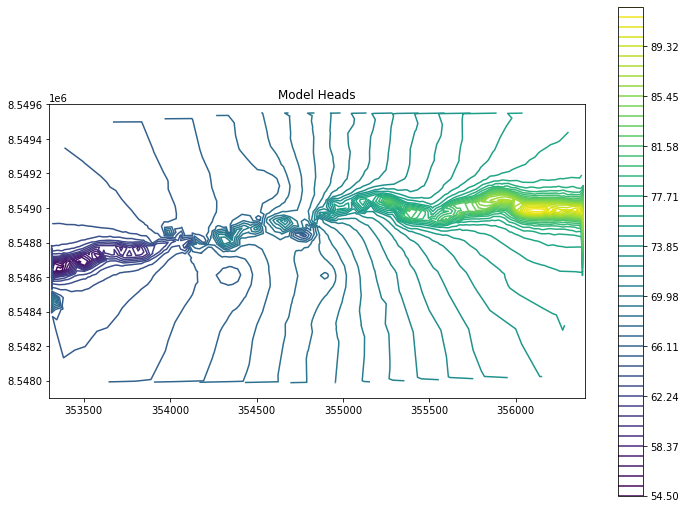

In [35]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)
#shp=flopy.plot.plot_shapefile('../examples/In/shp/Geospatial_model/ModelWell2.shp',ax=ax,radius=10)
#linecollection = mapview.plot_grid()

levels = np.linspace(np.nanmin(head),np.nanmax(head),num=50)
contour_set = mapview.contour_array(head,levels=levels)
t = ax.set_title("Model Heads")
plt.colorbar(contour_set, shrink=0.75)
plt.show()

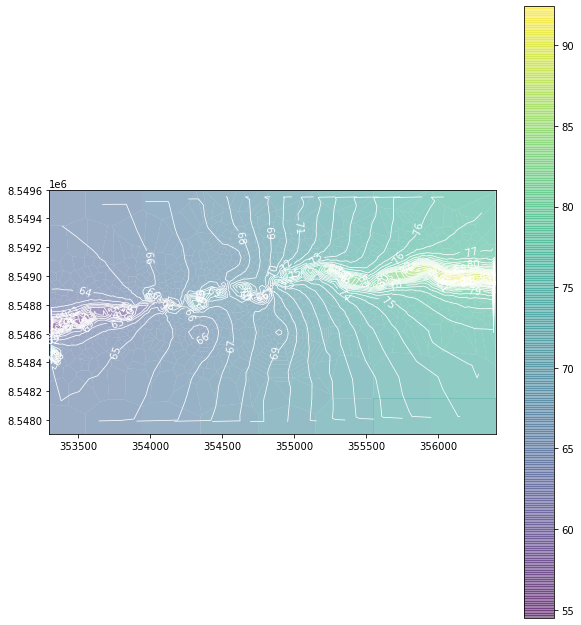

In [36]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)

quadmesh = mapview.plot_array(head, alpha=0.5)
levels = np.linspace(np.nanmin(head),np.nanmax(head),num=50)
c = mapview.contour_array(head, linewidths=0.75,colors='white',levels=levels)
plt.clabel(c, fmt='%3d')
#quiver = flopy.plot.plotutil.c(spd)
plt.colorbar(quadmesh, shrink=0.75)
plt.show()

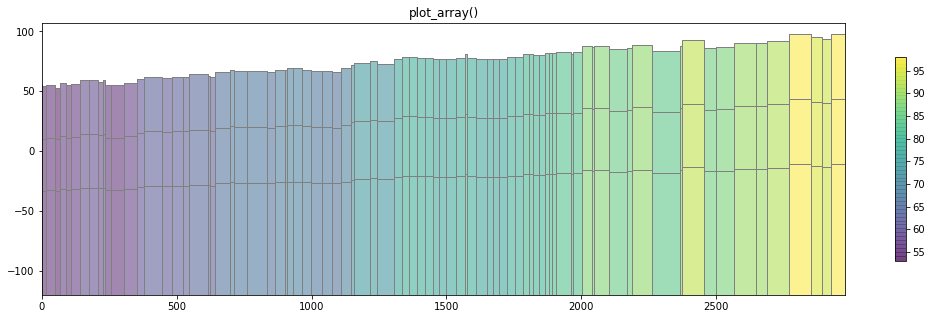

In [37]:
# get the head output for stress period 1 from the modflow6 head file
head = flopy.utils.HeadFile(os.path.join(model_ws, model_name+".hds"))
hdata = head.get_alldata()[0, :, :, :]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array()")

xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)